In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
# Loading dataset
data = pd.read_csv("TSLA.csv")
print("Dataset Overview:")
print(data.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB
None


In [5]:
# Display basic data preview
print("First five rows of the dataset:")
data.head()

First five rows of the dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [7]:
print("Last Five rows of the dataset:")
data.tail()

Last Five rows of the dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2955,2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


In [9]:
#Checking if there are any null values in the dataset.
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
#Describing the data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [13]:
#Checking for duplicated values
duplicates = data.duplicated()
duplicates
sum(duplicates)

0

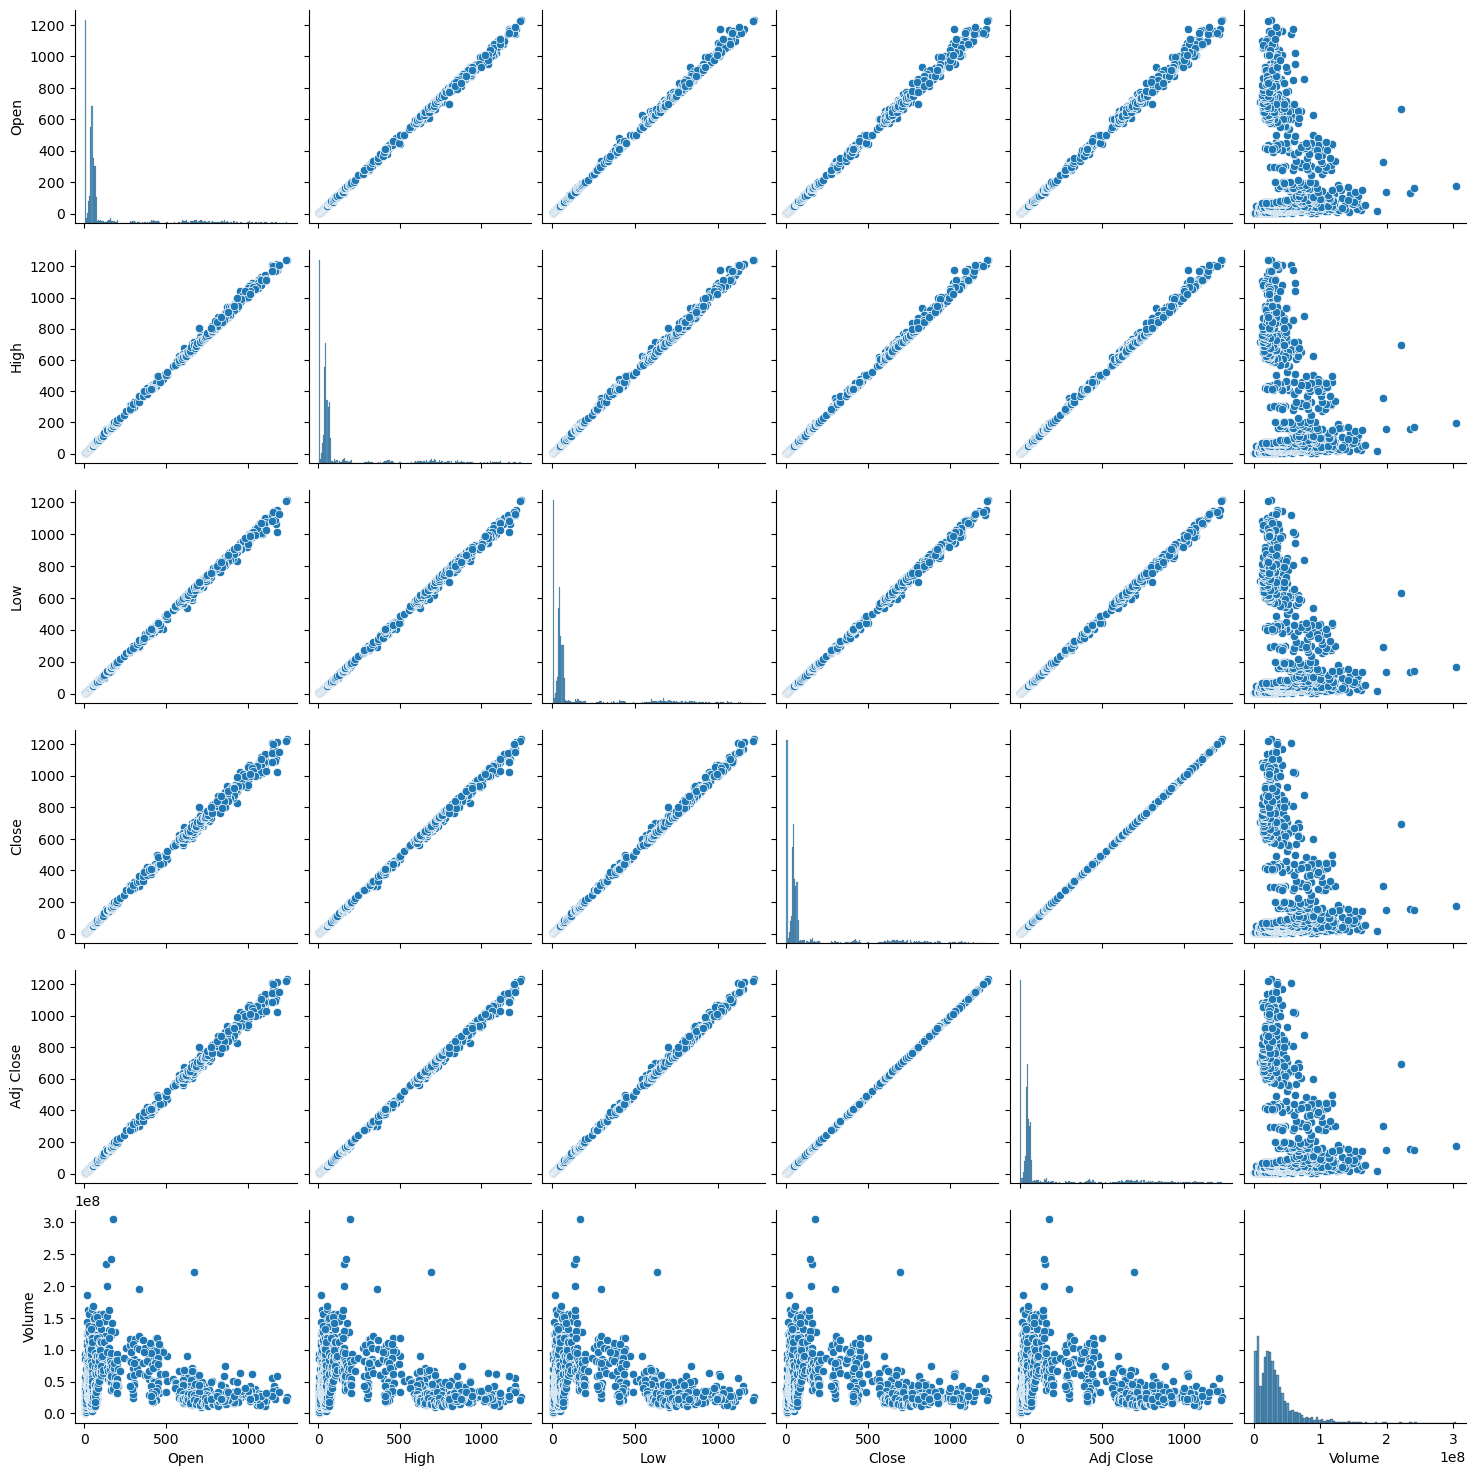

In [15]:
#Plotting a pairplot
sns.pairplot(data,kind ='scatter')

In [17]:
# Data Cleaning and Preprocessing
def preprocess_data(data):
    # Convert 'Date' to datetime and sort
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date')
    
    # Create additional features: daily range and average price
    data['Daily_Range'] = data['High'] - data['Low']
    data['Average_Price'] = (data['High'] + data['Low']) / 2
    
    # Normalize numerical features
    data['Volume'] = np.log1p(data['Volume'])  # Log-transform volume for better scaling
    return data

data = preprocess_data(data)

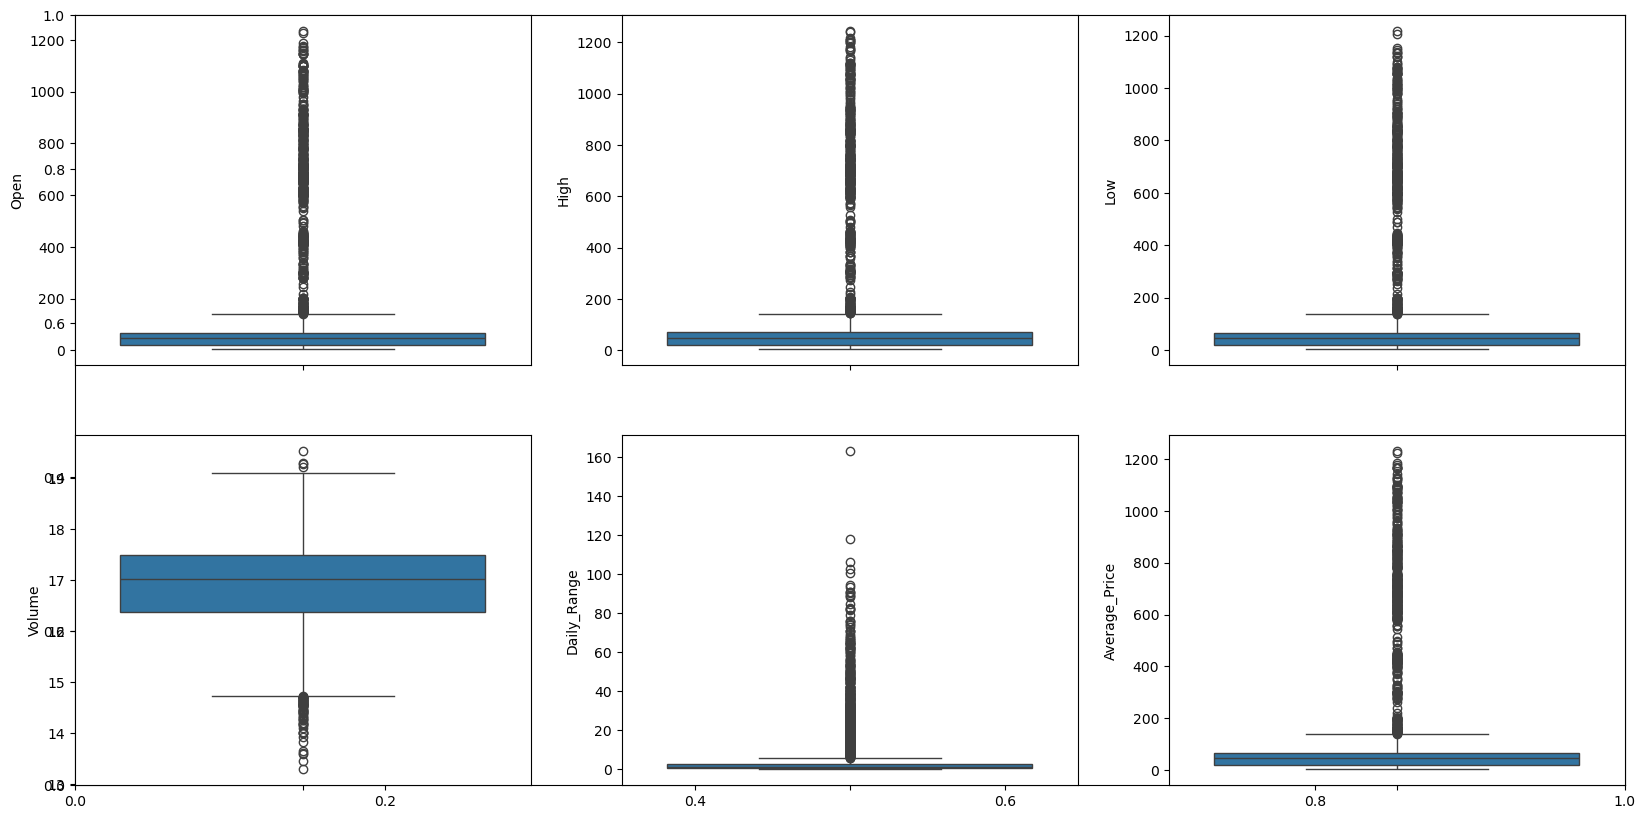

In [21]:
#Plotting a boxplot to check for Outliers
features = data[['Open', 'High', 'Low', 'Volume', 'Daily_Range', 'Average_Price']]

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(data[col])
plt.show()

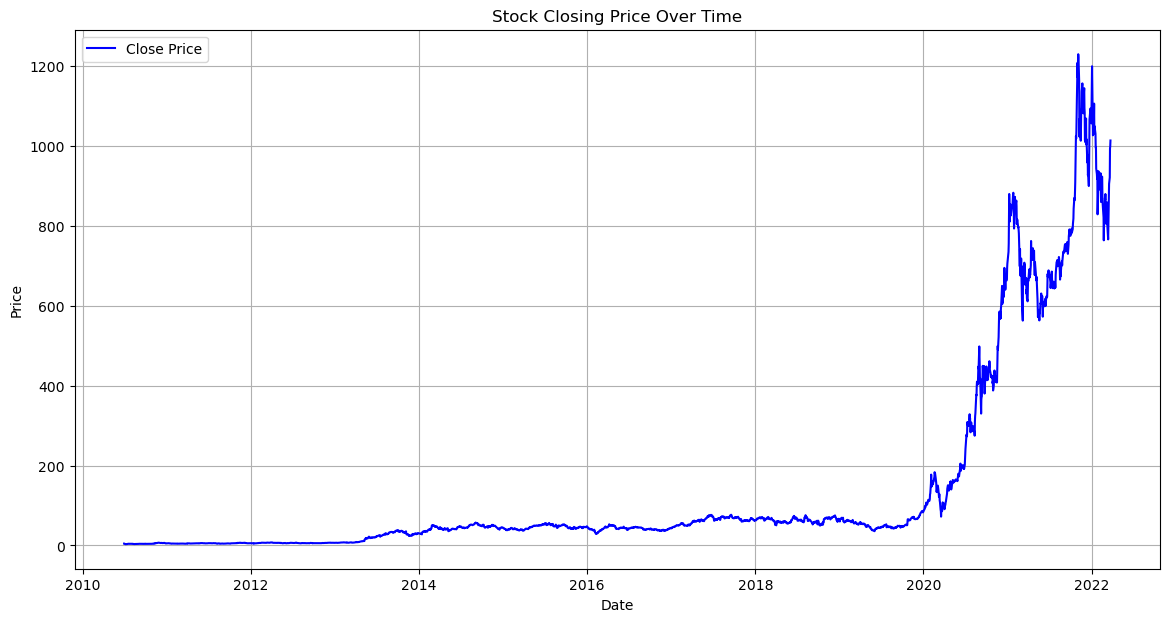

In [23]:
# Plot stock price trends
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

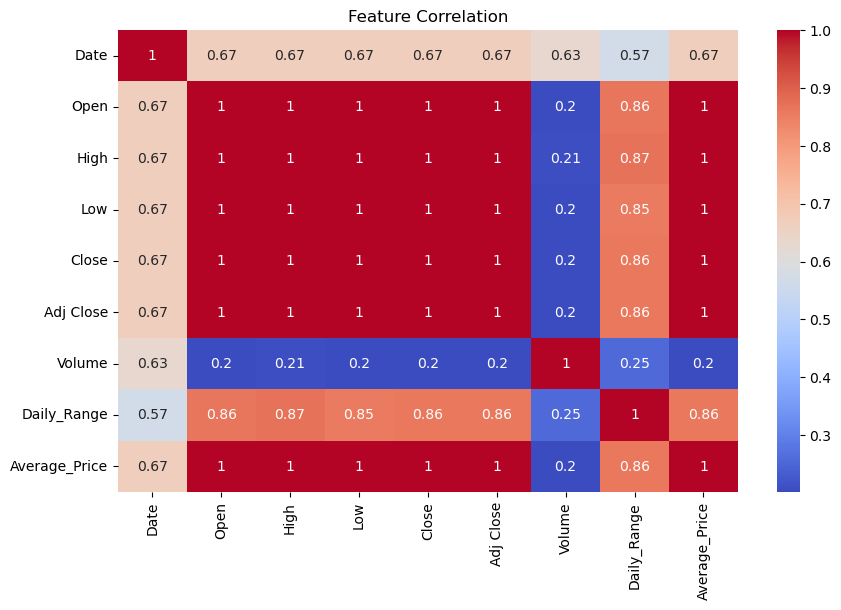

In [25]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

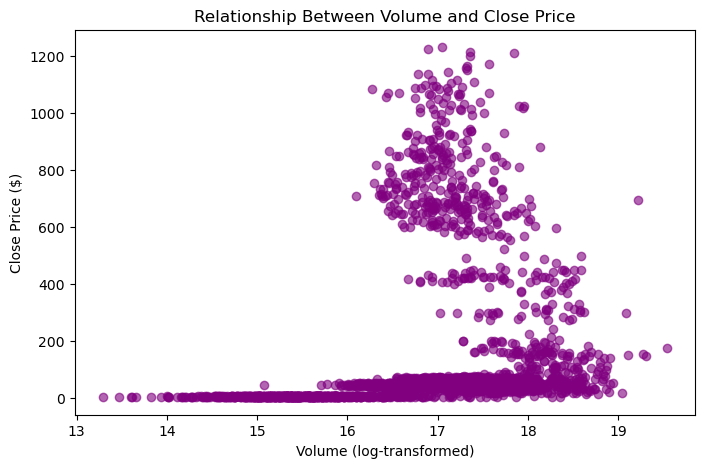

In [27]:
#Plotting the relationship between Volume and Close Price
plt.figure(figsize=(8, 5))
plt.scatter(data['Volume'], data['Close'], alpha=0.6, color='purple')
plt.title('Relationship Between Volume and Close Price')
plt.xlabel('Volume (log-transformed)')
plt.ylabel('Close Price ($)')
plt.savefig("scatter_volume_close.png")
plt.show()

In [29]:
# Prepare features and target
features = data[['Open', 'High', 'Low', 'Volume', 'Daily_Range', 'Average_Price']]
target = data['Close']

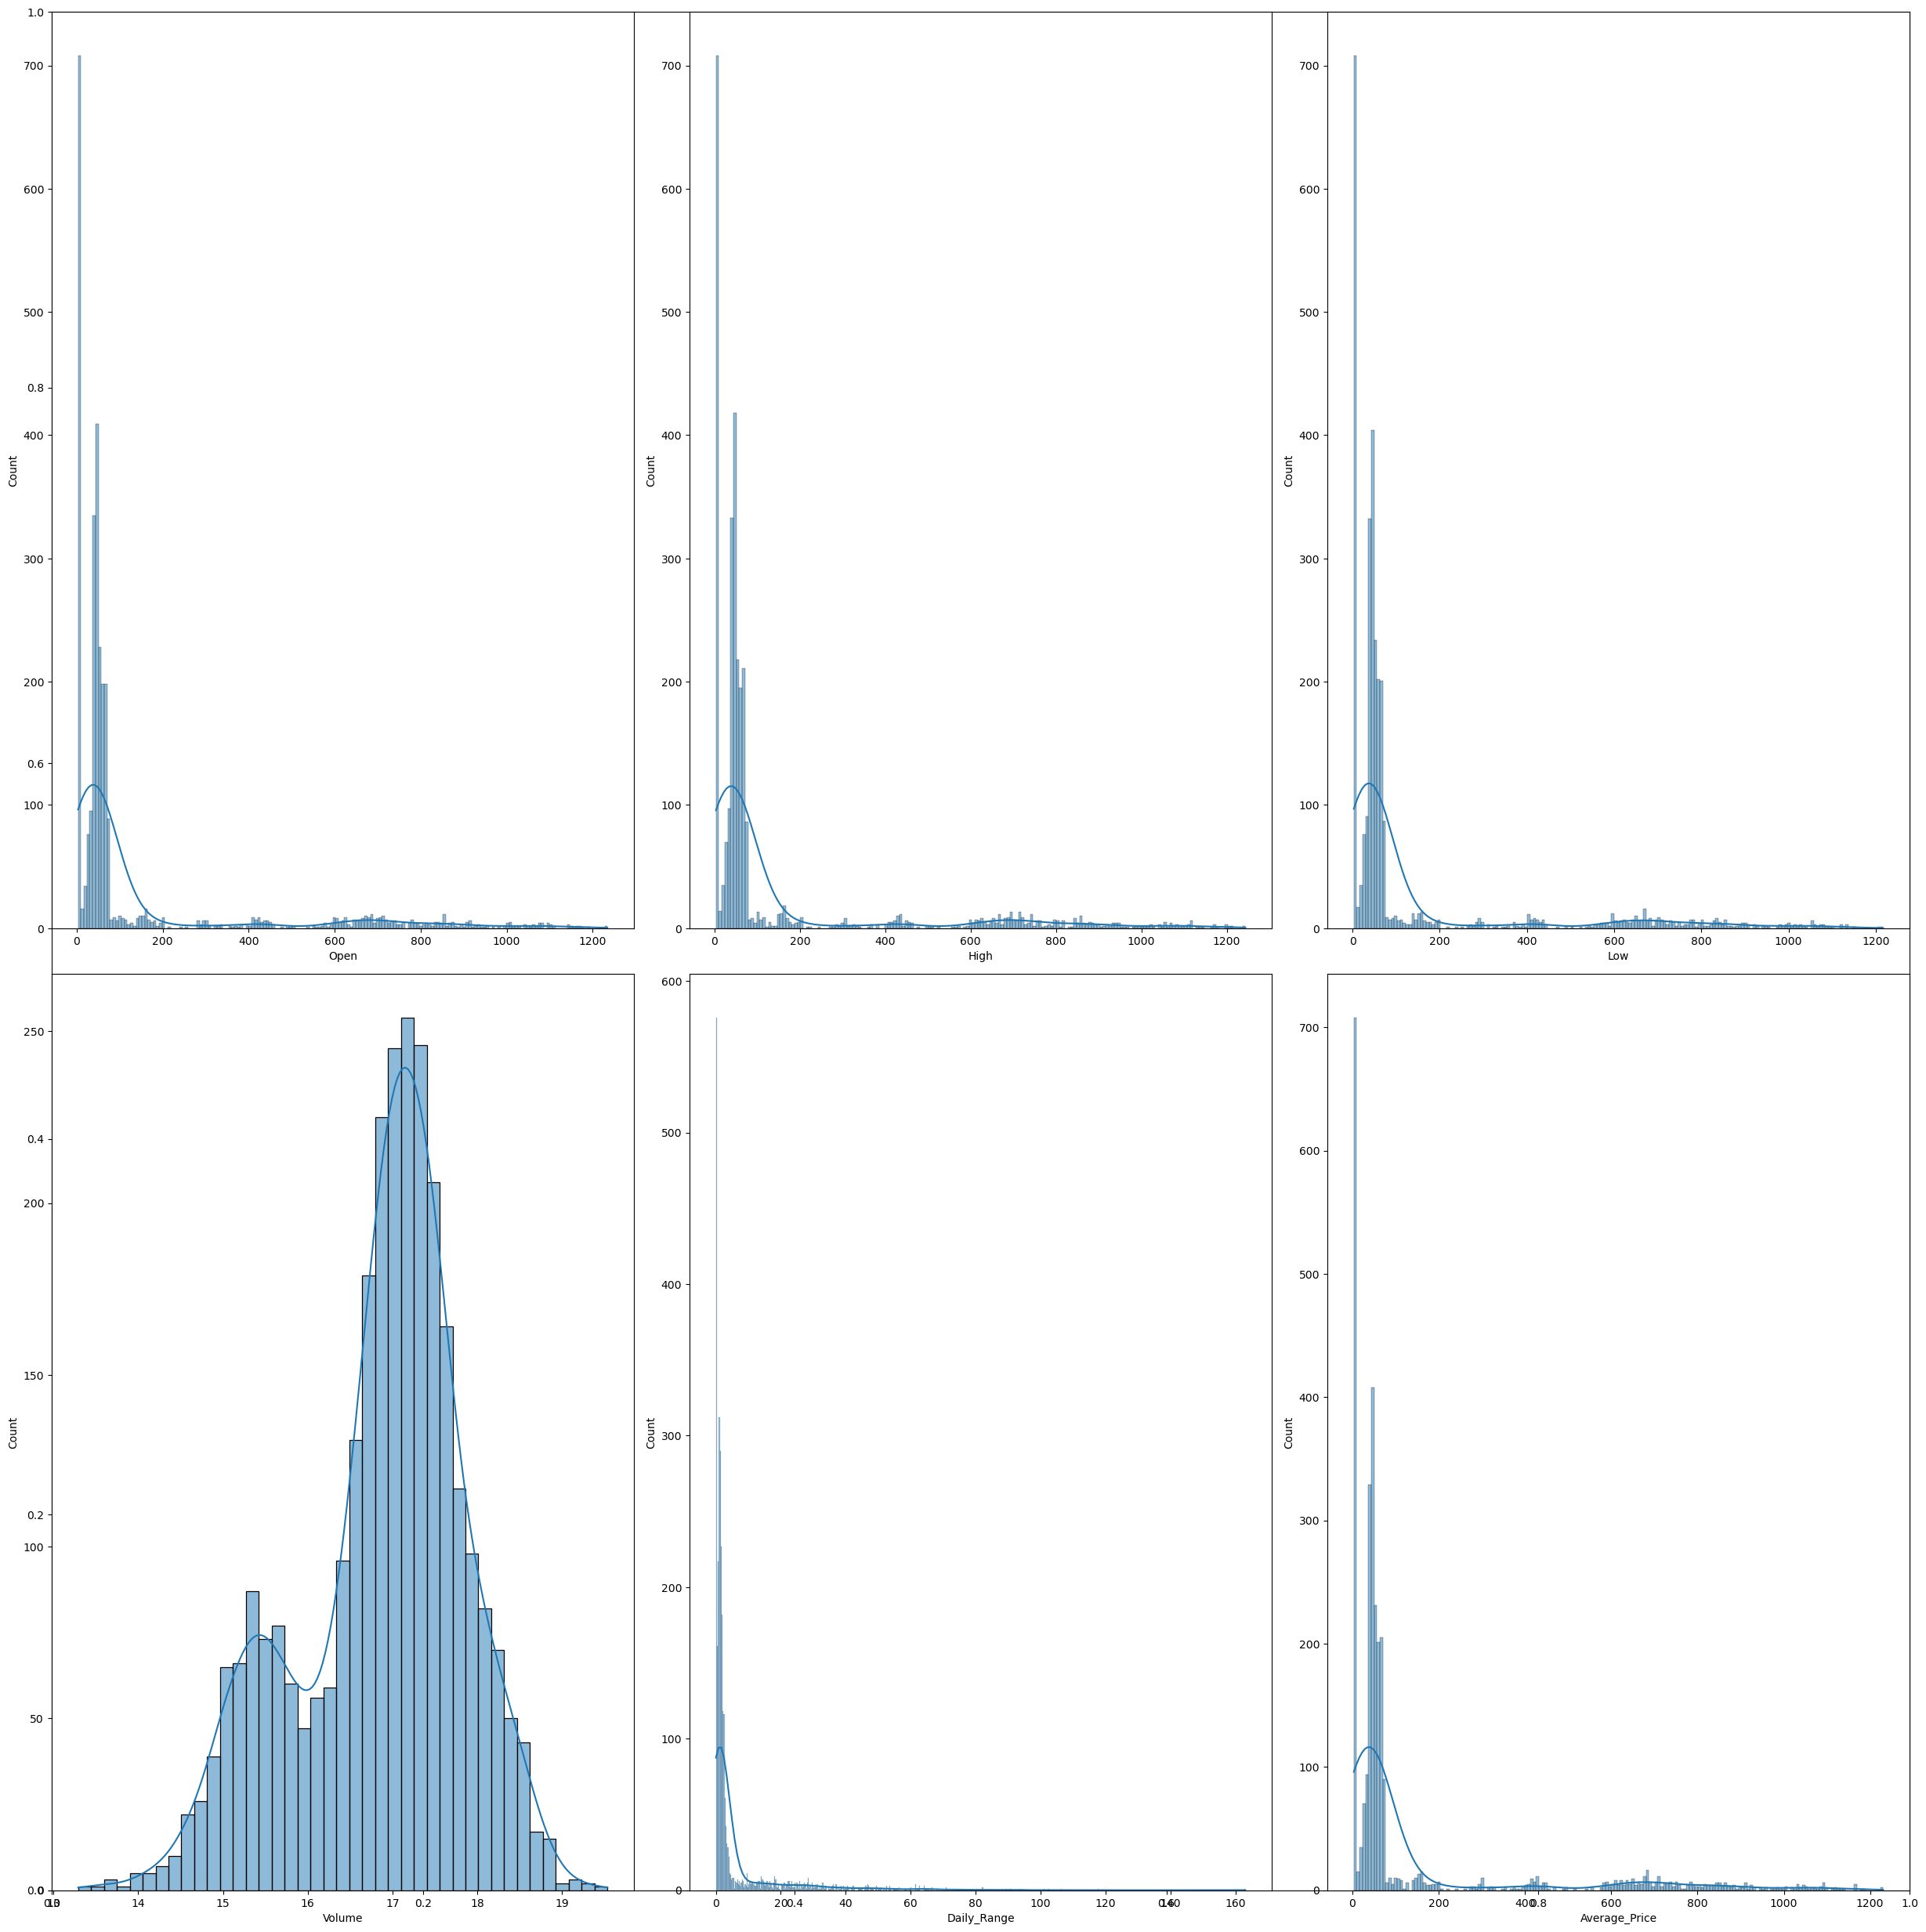

In [31]:
plt.subplots(figsize=(25,25))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.histplot(data[col],kde = True)
plt.tight_layout()
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [35]:
# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
print("Linear Regression Results:")
print("R-squared:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))

Linear Regression Results:
R-squared: 0.9996495852045998
MAE: 1.4201651242519937


In [37]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
    
print("Random Forest Results:")
print("R-squared:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

Random Forest Results:
R-squared: 0.9995956454931265
MAE: 1.7640644139695927


In [39]:
# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
    
print("XGBoost Results:")
print("R-squared:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))

XGBoost Results:
R-squared: 0.9988758205448351
MAE: 2.8064528517175877


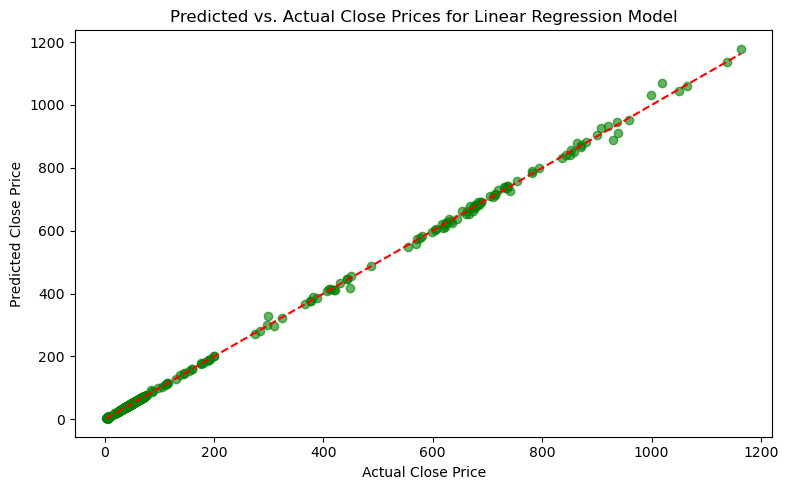

In [41]:
# Predicted vs. Actual Plot for Linear Regression Model
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='green')
plt.title('Predicted vs. Actual Close Prices for Linear Regression Model')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()

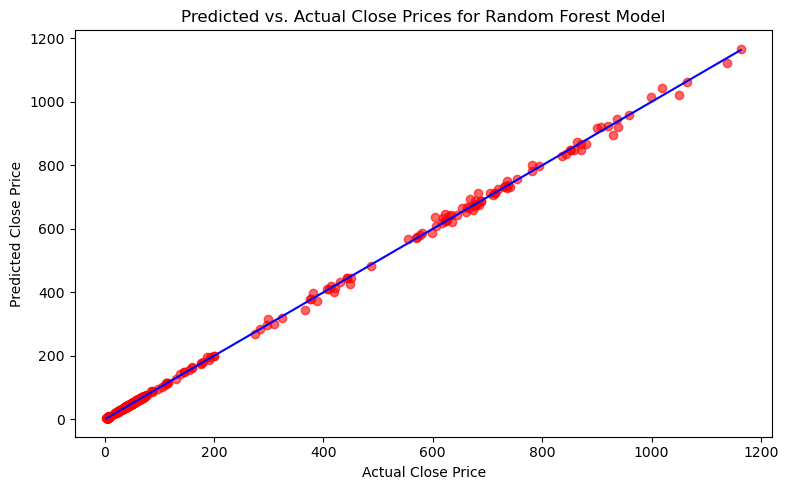

In [43]:
# Predicted vs. Actual Plot for Random Forest Model
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='red')
plt.title('Predicted vs. Actual Close Prices for Random Forest Model')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue')
plt.tight_layout()
plt.show()

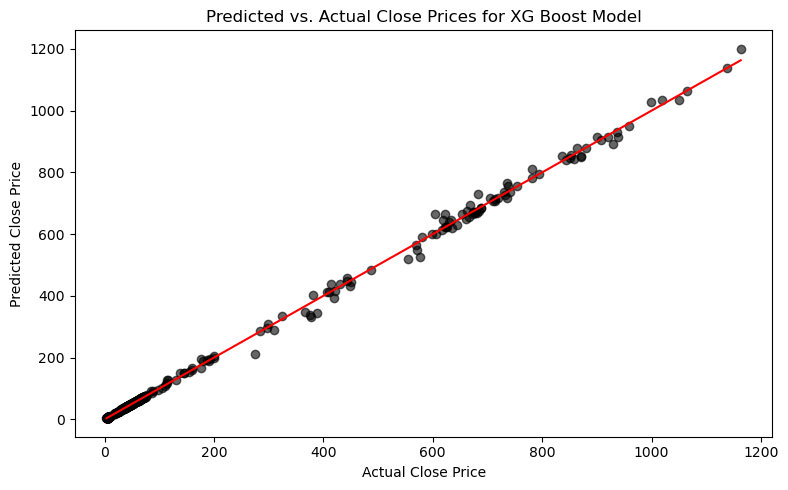

In [45]:
# Predicted vs. Actual Plot for XG Boost Model
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='black')
plt.title('Predicted vs. Actual Close Prices for XG Boost Model')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.tight_layout()
plt.show()